# Resolução do Exercício 1 da Atividade 2

In [ ]:
from sympy import symbols, integrate, Eq, solve, Heaviside, lambdify
import matplotlib.pyplot as plt
import numpy as np
import math
import string
%matplotlib inline

# CONSTANTES
letras = string.ascii_uppercase[:100]
enumCarregamento = {1: "Retangular", 2: "Triangular", 3: "Trapézoidal"}
enumApoio = {1: "Apoio de 1° gênero", 2: "Apoio de 2° gênero", 3: "Apoio de 3° gênero"}
enumEstabilidade = {1: "Hipoestática", 2: "Isostática", 3: "Hiperestática"}

def heaviside(x):
    return 1.0 if x >= 0 else 0.0

class CarregamentoPontual:
    def __init__(self, intensidade, posicao, angulacao):
      self.fy, self.fx = self.separaComponentes(intensidade, angulacao)
      self.posicao = posicao

    def separaComponentes(self, F, theta):
      theta = math.radians(theta)
      x = F * math.cos(theta)
      y = F * math.sin(theta)
      return x,y

class CarregamentoDistribuido:
  def __init__(self, tipo, w0, w1, p0, pf): #construtor
    self.tipo = enumCarregamento[tipo]
    self.w = [w0, w1] # w inicial e w final
    self.p = [p0, pf] # posição inicial e final

    self.x = symbols('x')
    self.resultante = integrate(self.funcao_w(), (self.x, self.p[0],self.p[1])) # calculo da integral de w(x) definida no intervalo de p0 a pf para encontrar a resultante
    self.centroide = integrate(self.funcao_w()*self.x, (self.x, self.p[0],self.p[1]))/self.resultante # calculo do centroide (posição em que a força resultante será aplicada)

  def funcao_w (self):
    if self.w[0] == self.w[1]:
      funcao_w = self.w[0]
    else:
      a = (self.w[1] - self.w[0])/(self.p[1] - self.p[0])
      b = self.w[0] - a*self.p[0]
      funcao_w = a*self.x + b

    return funcao_w

class Apoio:
    def __init__(self, letra, tipo, posicao = 0):
      self.letra = letra
      self.tipo = enumApoio[tipo]
      self.posicao = posicao

      self.fx = symbols(f'{letra}_x')
      self.fy = symbols(f'{letra}_y')

      if(self.tipo == enumApoio[1]):
        self.fx = 0

class Viga:
  def __init__(self):
    self.lista_apoios = []

    self.lista_carregamentos_pontuais = []
    self.lista_carregamentos_distribuidos = []
    self.lista_carregamentos = []

    self.comprimento = 0

    self.solucao = None

    self.V_vals = []
    self.M_vals = []

  def gerar_numIncognitas(self):
    numIncognitas = 0
    for i in range (len(self.lista_apoios)):
      if self.lista_apoios[i].tipo == enumApoio[1]:
        numIncognitas += 1
      elif self.lista_apoios[i].tipo == enumApoio[2]:
        numIncognitas += 2
      elif self.lista_apoios[i].tipo == enumApoio[3]:
        numIncognitas += 3
    return numIncognitas

  def get_estabilidade(self):
    numIncognitas = self.gerar_numIncognitas()
    if numIncognitas > 3:
      return enumEstabilidade[3]
    elif numIncognitas == 3:
      return enumEstabilidade[2]
    else:
      return enumEstabilidade[1]

  def calcula_reacoes(self):
    vars_fx = []
    vars_fy = []
    M = 0
    soma = 0

    for i in range(len(self.lista_apoios)):
      if(self.lista_apoios[i].tipo != enumApoio[1]): vars_fx.append(self.lista_apoios[i].fx)

      vars_fy.append(self.lista_apoios[i].fy)

      if(self.lista_apoios[i].tipo == enumApoio[3]):
        M = symbols('M')
        soma += M

      if self.lista_apoios[i].tipo != enumApoio[3] and i > 0:
        soma += self.lista_apoios[i].fy*(self.lista_apoios[i].posicao - self.lista_apoios[0].posicao)

    for carregamento in self.lista_carregamentos: soma -= carregamento.fy*carregamento.posicao

    fx = Eq(sum(vars_fx) - sum(self.lista_carregamentos[i].fx for i in range(len(self.lista_carregamentos))), 0) # soma de todos fx - soma dos carregamentos em fx
    fy = Eq(sum(vars_fy) - sum(self.lista_carregamentos[i].fy for i in range(len(self.lista_carregamentos))), 0) # soma de todos fy - soma dos carregamentos em fy
    momento = Eq(soma, 0)

    self.solucao = solve((fx, fy, momento), *vars_fx, *vars_fy, M) #solução

    return self.solucao

  def calcular_esforcos_internos(self, x):
      V = 0
      M = 0

      for apoio in self.lista_apoios:
          if apoio.fy in self.solucao:
              reacao = self.solucao[apoio.fy]
              pos = apoio.posicao
              V += reacao * heaviside(x - pos)
              M += reacao * (x - pos) * heaviside(x - pos)

      for carga in self.lista_carregamentos_pontuais:
          Fy = carga.fy
          pos = carga.posicao
          V -= Fy * heaviside(x - pos)
          M -= Fy * (x - pos) * heaviside(x - pos)

      for carga_dist in self.lista_carregamentos_distribuidos:
          a = carga_dist.p[0]
          b = carga_dist.p[1]

          if carga_dist.tipo == "Retangular":
              w = carga_dist.w[0]

              if x > a:
                  if x <= b:
                      V -= w * (x - a)
                      M -= w * (x - a)**2 / 2
                  else:
                      V -= w * (b - a)
                      M -= w * (b - a)**2 / 2 + w * (b - a) * (x - b)

          elif carga_dist.tipo in ["Triangular", "Trapézoidal"]:
              w1 = carga_dist.w[0]
              w2 = carga_dist.w[1]

              if x > a:
                  if x <= b:
                      alpha = (x - a) / (b - a)
                      w_x = w1 + (w2 - w1) * alpha
                      V -= (w1 + w_x) * (x - a) / 2
                      M -= (2 * w1 + w_x) * (x - a)**2 / 6
                  else:
                      R = (w1 + w2) * (b - a) / 2
                      xc = (b - a) * (2 * w1 + w2) / (3 * (w1 + w2))
                      M_b = (w1 + w2) * (b - a)**2 / 6
                      V -= R
                      M -= M_b + R * (x - (a + xc))

      return V, M

  def calcular_Mx_Vx(self):
    pontos_transicao = set()
    for carga in self.lista_carregamentos_distribuidos:
      pontos_transicao.add(carga.p[0])
      pontos_transicao.add(carga.p[1])
    for carga in self.lista_carregamentos_pontuais:
        pontos_transicao.add(carga.posicao)
    for apoio in self.lista_apoios:
        pontos_transicao.add(apoio.posicao)

    x_base = np.linspace(0, self.comprimento, 500)
    x_transicao = []

    for p in pontos_transicao:
        # Garante que os pontos de transição não ultrapassem o comprimento da viga
        start = max(p - 0.001, 0)
        end = min(p + 0.001, self.comprimento)
        x_transicao.extend(np.linspace(start, end, 10))

    x_vals = np.sort(np.unique(np.concatenate([x_base, x_transicao])))
    x_vals = x_vals[x_vals <= self.comprimento]  # Remove pontos além do comprimento

    for x in x_vals:
        V, M = self.calcular_esforcos_internos(x)
        self.V_vals.append(V)
        self.M_vals.append(M)

    return x_vals, self.V_vals, self.M_vals

  def plotar_diagramas(self):
    x_vals, _, _ = self.calcular_Mx_Vx()

    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.plot(x_vals, self.V_vals, 'b')
    plt.title('Diagrama de Força Cortante')
    plt.xlabel('Posição (m)')
    plt.ylabel('V(x) [N]')
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(x_vals, self.M_vals, 'r')
    plt.title('Diagrama de Momento Fletor')
    plt.xlabel('Posição (m)')
    plt.ylabel('M(x) [Nm]')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

  def plotar_viga(self):
    plt.figure(figsize=(12, 6))

    # Plota viga
    plt.plot([0, self.comprimento], [0, 0], 'k-', linewidth=2)

    # Plota apoios
    for apoio in self.lista_apoios:
      if apoio.tipo == enumApoio[1]:  # Apoio de 1º gênero
        plt.plot([apoio.posicao], [0], 'k^', markersize=10, label=f'Apoio {apoio.letra} de 1° gênero')
      elif apoio.tipo == enumApoio[2]:  # Apoio de 2º gênero
        plt.plot([apoio.posicao], [0], 'ko', markersize=10, label=f'Apoio {apoio.letra} de 2° gênero')
      elif apoio.tipo == enumApoio[3]:  # Apoio de 3º gênero
        plt.plot([apoio.posicao], [0], 'ks', markersize=10, label=f'Apoio {apoio.letra} de 3° gênero')

    # Plota cargas
    for carga in self.lista_carregamentos_pontuais:
      plt.arrow(carga.posicao, 2, 0, -1.5, head_width=0.1, head_length=0.2, fc='blue', ec='blue', label='Carga Pontual')

    for carga in self.lista_carregamentos_distribuidos:
      x = np.linspace(carga.p[0], carga.p[1], 100)
      if carga.tipo == "Retangular":
        y = np.ones_like(x) * carga.w[0]
        label = 'Carga Distribuída Retangular'
      elif carga.tipo == "Triangular":
        y = np.linspace(carga.w[0], carga.w[1], 100)
        label = 'Carga Distribuída Triangular'
      else:
        y = np.linspace(carga.w[0], carga.w[1], 100)
        label = 'Carga Distribuída Trapézoidal'
      plt.fill_between(x, 0, -y / 1000, alpha=0.3, label=label)

    # Plota reações nos apoios
    escala = 1  # Fator de escala para as reações
    for apoio in self.lista_apoios:
      plt.arrow(apoio.posicao, 0, 0, 2, head_width=0.1, head_length=0.2, fc='red', ec='red')  # Seta vertical

      if apoio.tipo != enumApoio[1]:
        plt.arrow(apoio.posicao - 2.5, 0, 2, 0, head_width=0.1, head_length=0.2, fc='red', ec='red')  # Seta horizontal

    plt.grid(True)
    plt.axis('equal')
    plt.title('Análise da Viga')
    plt.xlabel('Posição (m)')
    plt.ylabel('Carga (N/m)')
    plt.legend()
    plt.show()

  def imprimir_resultados(self):
    print("\n\n====================================")
    print(f"RESULTADO:")
    print("====================================")

    for i in range(len(self.lista_carregamentos)):
        print(f"\nCarregamento {i+1}:")
        print(f"Fx: {self.lista_carregamentos[i].fx:.2f}")
        print(f"Fy: {self.lista_carregamentos[i].fy:.2f}")
        print(f"Posição: {self.lista_carregamentos[i].posicao:.2f}")

    print("\n====================================")
    print("\nReações nos apoios:")
    for dado in self.solucao:
        print(f"{dado}: {self.solucao[dado]:.2f}")
    print("\n====================================")

  def menu_viga(self):
    print("\n=== ADICIONE A VIGA ===")
    print("\nTIPOS DE CARREGAMENTO:")
    carregamentos_pontuais = int(input("Insira quantos carregamentos pontuais existem na sua viga: "))
    carregamentos_distribuidos = int(input("Insira quantos carregamentos distribuídos existem na sua viga: "))

    if(carregamentos_pontuais > 0):
      print("\nCARREGAMENTO PONTUAL:")

      for i in range (carregamentos_pontuais):
        intensidade = float(input(f"Insira a intensidade da {i+1}° carga pontual (N): "))
        posicao = float(input(f"Insira a posição da {i+1}° carga pontual (m): "))
        angulacao = float(input(f"Insira a angulação em relação ao eixo y da {i+1}° carga pontual: "))

        self.lista_carregamentos_pontuais.append(CarregamentoPontual(intensidade, posicao, angulacao))

    print("\nCARREGAMENTO DISTRIBUIDO:")
    print("\nTIPOS DE CARREGAMENTOS DISTRIBUIDOS:")
    print("1. Retangular")
    print("2. Triangular")
    print("3. Trapézoidal")

    w0, w1, p0, p1 = 0, 0, 0, 0
    for i in range (carregamentos_distribuidos):
      tipo = int(input(f"\nInsira o número correspondente ao tipo do {i+1}° carregamento distribuido: "))

      if(tipo == 1):
        w0 = float(input(f"Insira w do {i+1}° carregamento distribuido (N/m): "))
        w1 = w0
      else:
        w0 = float(input(f"Insira w{i} do {i+1}° carregamento distribuido (N/m): "))
        w1 = float(input(f"Insira w{i+1} do {i+1}° carregamento distribuido (N/m): "))

      p0 = float(input(f"Insira a posição inicial do {i+1}° carregamento distribuido (m): "))
      pf = float(input(f"Insira a posição final do {i+1}° carregamento distribuido (m): "))

      self.lista_carregamentos_distribuidos.append(CarregamentoDistribuido(tipo, w0, w1, p0, pf))

    print("\nAPOIOS:")
    num_apoios = int(input("Insira quantos apoios existem na sua viga: "))
    lista_apoios = []

    print("\nTIPOS DE APOIO:")
    print("1. Apoio de 1° gênero")
    print("2. Apoio de 2° gênero")
    print("3. Apoio de 3° gênero")

    for i in range (num_apoios):
      tipo_apoio = int(input(f"\nInsira o número correspondente ao tipo do Apoio {letras[i]}: "))
      posicao = float(input(f"Insira a posição do Apoio {letras[i]} (m): "))

      self.lista_apoios.append(Apoio(letras[i], tipo_apoio, posicao))

    self.comprimento = float(input("\nInsira o comprimento da viga (m): "))
    self.lista_carregamentos = [CarregamentoPontual(self.lista_carregamentos_distribuidos[i].resultante, self.lista_carregamentos_distribuidos[i].centroide, 0) for i in range(carregamentos_distribuidos)] + self.lista_carregamentos_pontuais

# Questão 1

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

class Retangulo:
    def __init__(self, pontos, eh_vazamento=False):
        self.pontos = pontos
        self.eh_vazamento = eh_vazamento

        self.base = abs(pontos[1][0] - pontos[0][0])  # Diferença entre x1 e x2
        self.altura = abs(pontos[2][1] - pontos[1][1])  # Diferença entre y2 e y1
        self.area = self.base * self.altura

        # Calcula o centroide do retângulo
        self.centroide = self.calcula_centroide_retangulo()

        self.Ix_ = 1 / 12 * self.base * self.altura**3
        self.Iy_ = 1 / 12 * self.altura * self.base**3

    def calcula_centroide_retangulo(self):
        """
        Calcula o centroide de um único retângulo.
        """
        x_medio = (self.pontos[0][0] + self.pontos[1][0]) / 2  # Média dos x
        y_medio = (self.pontos[0][1] + self.pontos[2][1]) / 2  # Média dos y
        return (x_medio, y_medio)

def captura_retangulos(eh_vazamento=False):
    num_retangulos = int(input("Insira o número de retângulos existentes na sua figura: "))
    retangulos = []

    for i in range(num_retangulos):
        pontos = []
        print()
        j = 0
        while j < 4:
            entrada = input(f"Digite um ponto no formato x,y correspondente ao {j+1}º vértice do seu {i+1}º retângulo (m): ")

            try:
                x, y = map(float, entrada.split(','))
                pontos.append((x, y))
                j += 1
            except ValueError:
                print("Entrada inválida! Digite no formato x,y")

        retangulo = Retangulo(ordenar_vertices(pontos), eh_vazamento)
        retangulos.append(retangulo)

    return retangulos

def ordenar_vertices(vertices):
    # Ordena os vértices primeiro por y (ascendente) e depois por x (ascendente)
    vertices_ordenados = sorted(vertices, key=lambda v: (v[1], v[0]))

    # Separa os vértices inferiores e superiores
    inferiores = sorted(vertices_ordenados[:2], key=lambda v: v[0])
    superiores = sorted(vertices_ordenados[2:], key=lambda v: -v[0])

    # Junta os vértices na ordem correta
    return [inferiores[0], inferiores[1], superiores[0], superiores[1]]

def calcula_centroide(retangulos):
    """
    Calcula o centroide de uma figura composta por retângulos.
    O centroide é a média ponderada dos centroides de cada retângulo,
    onde o peso é a área de cada retângulo.
    """
    somatorio_area = 0
    somatorio_x = 0
    somatorio_y = 0

    for retangulo in retangulos:
        if retangulo.eh_vazamento:
            area = -retangulo.area  # Área negativa para vazamentos
        else:
            area = retangulo.area

        # Centroide do retângulo
        x_medio, y_medio = retangulo.centroide

        # Acumular para o cálculo do centroide total
        somatorio_area += area
        somatorio_x += x_medio * area
        somatorio_y += y_medio * area

    # Calcular o centroide total
    if somatorio_area == 0:
        raise ValueError("A área total da figura é zero. Não é possível calcular o centroide.")

    x_centroide = somatorio_x / somatorio_area
    y_centroide = somatorio_y / somatorio_area

    return (x_centroide, y_centroide)

def calcula_momento_inercia(retangulos, x_centroide, y_centroide):
    """
    Calcula o momento de inércia de uma figura composta por múltiplos retângulos.
    Fórmulas:
        Ix = Σ (Ix_ + A * dy²)
        Iy = Σ (Iy_ + A * dx²)
    onde:
        - Ix_ e Iy_ são os momentos de inércia dos retângulos individuais em seus próprios centroides
        - A é a área de cada retângulo (positiva para retângulos principais, negativa para vazamentos)
        - dx e dy são as distâncias entre os centroides individuais e o centroide da figura total
    """
    Ix_total = 0
    Iy_total = 0
    dx = 0
    dy = 0

    for retangulo in retangulos:
        # Área do retângulo (positiva para retângulos principais, negativa para vazamentos)
        area = retangulo.area if not retangulo.eh_vazamento else -retangulo.area

        # Centroide do retângulo
        x_medio, y_medio = retangulo.centroide

        # Distâncias ao centroide da figura
        dx = x_medio - x_centroide
        dy = y_medio - y_centroide

        # Cálculo do momento de inércia usando o teorema dos eixos paralelos
        if not retangulo.eh_vazamento:
            Ix_total += retangulo.Ix_ + abs(area) * dy**2  # Usamos abs(area) para garantir que o sinal não afete o cálculo
            Iy_total += retangulo.Iy_ + abs(area) * dx**2

        if retangulo.eh_vazamento:
            Ix_total -= retangulo.Ix_ + abs(area) * dy**2  # Usamos abs(area) para garantir que o sinal não afete o cálculo
            Iy_total -= retangulo.Iy_ + abs(area) * dx**2

    return Ix_total, Iy_total

def plotagem(retangulos, centroide=None, Ix=None, Iy=None):
    plt.figure()
    for retangulo in retangulos:
        # Define a cor com base se é um vazamento ou não
        if retangulo.eh_vazamento:
            cor = 'white'  # Vazamentos são plotados como brancos
            borda = 'grey'  # Borda preta para destacar o vazamento
        else:
            cor = 'purple'  # Retângulos principais são plotados em azul
            borda = 'purple'

        # Desenha os retângulos conectando os pontos
        pontos = retangulo.pontos
        pontos.append(pontos[0])  # Fechar o retângulo conectando o último ponto ao primeiro
        x_coords, y_coords = zip(*pontos)
        plt.plot(x_coords, y_coords, marker='o', color=borda, label='Vazamento' if retangulo.eh_vazamento else 'Retângulo Principal')
        plt.fill(x_coords, y_coords, color=cor, edgecolor=borda, alpha=0.8 if not retangulo.eh_vazamento else 1.0)  # Preenchimento

    # Plotar o centroide, se fornecido
    if centroide:
        plt.scatter(centroide[0], centroide[1], color='green', marker='x', label='Centroide', s=100, linewidths=2)

        # Exibir os valores do centroide e momentos de inércia no gráfico
        texto_centroide = f'Centroide: ({centroide[0]:.2f}, {centroide[1]:.2f})'
        texto_Ix = f'Ix: {Ix:.2e}'
        texto_Iy = f'Iy: {Iy:.2e}'

        plt.text(0.02, 0.98, texto_centroide, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))
        plt.text(0.02, 0.92, texto_Ix, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))
        plt.text(0.02, 0.86, texto_Iy, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Configuração Final da Figura')
    plt.grid(True)
    plt.legend()
    plt.show()

def menu_retangulos(retangulos):
    print("\n1. Adicionar figura principal")
    print("2. Adicionar Vazamento")
    print("3. Finalizar e Calcular")

    opcao = int(input("\nInsira a opção desejada: "))

    if opcao == 1:
        retangulos.extend(captura_retangulos())  # Adiciona retângulos à lista principal
        #plotagem(retangulos)
        return menu_retangulos(retangulos)

    elif opcao == 2:
        retangulos.extend(captura_retangulos(eh_vazamento=True))  # Adiciona vazamentos
        #plotagem(retangulos)
        return menu_retangulos(retangulos)

    elif opcao == 3:
        if not retangulos:
          print("Nenhum retângulo foi adicionado. Adicione retângulos antes de calcular o centroide.")
        else:
          centroide = calcula_centroide(retangulos)

          Ix, Iy = calcula_momento_inercia(retangulos, centroide[0], centroide[1])
          print(f"\nCentroide: {centroide[0]:.2f} m, {centroide[1]:.2f} m")
          print(f"\nMomento de Inércia em X: {Ix:.2e} m⁴")
          print(f"Momento de Inércia em Y: {Iy:.2e} m⁴")
          print()

          print("OS GRÁFICOS ESTÃO COMENTADOS, PARA MOSTRA-LOS BASTA DESCOMENTAR PLOTAGEM NO CÓDIGO!")
          #plotagem(retangulos, centroide, Ix, Iy)
          return

    else:
        print("Opção inválida. Tente novamente.")
        return menu_retangulos(retangulos)

#retangulos = []  # Lista de retângulos principal
#menu_retangulos(retangulos)

# Questão 2

In [ ]:
def calcular_tensoes(M, Ix, y_centroide, altura_total):
    """
    Calcula as tensões máximas de tração e compressão na seção transversal.
    Parâmetros:
        M: Momento fletor (Nm).
        Ix: Momento de inércia da seção transversal (m^4).
        y_centroide: Posição do centroide em relação à base da seção (m).
        altura_total: Altura total da seção transversal (m).
    Retorna:
        sigma_tracao: Tensão máxima de tração (Pa).
        sigma_compressao: Tensão máxima de compressão (Pa).
    """

    c_tracao = altura_total - y_centroide
    c_compressao = y_centroide

    # Tensões máximas
    sigma_tracao = (M * c_tracao) / Ix
    sigma_compressao = (M * c_compressao) / Ix

    return sigma_tracao, sigma_compressao

1. Calcular Tensões Máximas (com momento fletor manual)
2. Calcular Tensões Máximas de uma Viga (com momento fletor calculado)

Defina a seção transversal: 

1. Adicionar figura principal
2. Adicionar Vazamento
3. Finalizar e Calcular




1. Adicionar figura principal
2. Adicionar Vazamento
3. Finalizar e Calcular

Centroide: 0.04 m, 0.03 m

Momento de Inércia em X: 3.63e-07 m⁴
Momento de Inércia em Y: 9.33e-07 m⁴



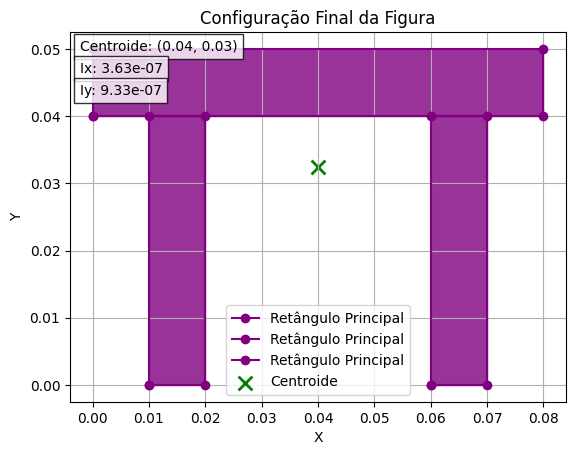

In [ ]:
%matplotlib inline

def calcula_tensoes_manual():
    print("\nDefina a seção transversal: ")
    retangulos = []
    menu_retangulos(retangulos)

    M = float(input("Insira o valor do momento fletor (M): "))
    altura_total = float(input("Insira a altura total da seção transversal: "))

    centroide = calcula_centroide(retangulos)
    Ix, Iy = calcula_momento_inercia(retangulos, centroide[0], centroide[1])

    sigma_tracao, sigma_compressao = calcular_tensoes(M, Ix, centroide[1], altura_total)

    print(f"\nTensão máxima de tração: {sigma_tracao/(10**6):.2f} MPa")
    print(f"Tensão máxima de compressão: {sigma_compressao/(10**6):.2f} MPa")

def calcula_tensoes():
      viga = Viga()
      viga.menu_viga()

      if viga.gerar_numIncognitas() != 3:
        print(f"ERRO: Vigas Hiperestáticas e/ou Hipoestáticas não podem ser calculadas.")
        exit(1)
      else:
        solucao = viga.calcula_reacoes()
        viga.imprimir_resultados()

        print("OS GRÁFICOS ESTÃO COMENTADOS, PARA MOSTRA-LOS BASTA DESCOMENTAR AS PLOTAGEM NO CÓDIGO!")
        #viga.plotar_viga()

      print("\nDefina a seção transversal da viga: ")
      retangulos = []
      menu_retangulos(retangulos)

      viga.calcular_Mx_Vx()
      M_max = max(abs(M) for M in viga.M_vals)

      # Dados da seção transversal
      altura_total = float(input("Insira a altura total da seção transversal (m): "))

      # Calcular tensões
      centroide = calcula_centroide(retangulos)
      Ix, Iy = calcula_momento_inercia(retangulos, centroide[0], centroide[1])
      sigma_tracao, sigma_compressao = calcular_tensoes(M_max, Ix, centroide[1], altura_total)

      print(f"\nMomento fletor máximo: {M_max:.2f} Nm")
      print(f"Tensão máxima de tração: {sigma_tracao/(10**6):.2f} MPa")
      print(f"Tensão máxima de compressão: {sigma_compressao/(10**6):.2f} MPa")


print("1. Calcular Tensões Máximas (com momento fletor manual)")
print("2. Calcular Tensões Máximas de uma Viga (com momento fletor calculado)")

def menu_tensoes():
  opcao = int(input("\nInsira a opção desejada: "))

  if opcao == 1:
    calcula_tensoes_manual()
  elif opcao == 2:
    calcula_tensoes()
  else:
    print("Opção inválida. Tente novamente.")
    return menu_tensoes()

menu_tensoes()